In [ ]:
import time
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import (
    Dataset,
    DataLoader, random_split
)

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
import seaborn as sns

import time
import random

%matplotlib inline

sns.set(font_scale=1.3, palette="Set2")

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

___

### Нейросетевой подход для предсказании временного ряда

In [ ]:
df = pd.read_csv("electricity.txt", sep=",", index_col=0)
df.drop(
    ["DailySeasonality", "WeeklySeasonality", "Time"], axis=1, inplace=True
)
df.head()

,Consumption,Temperature
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60


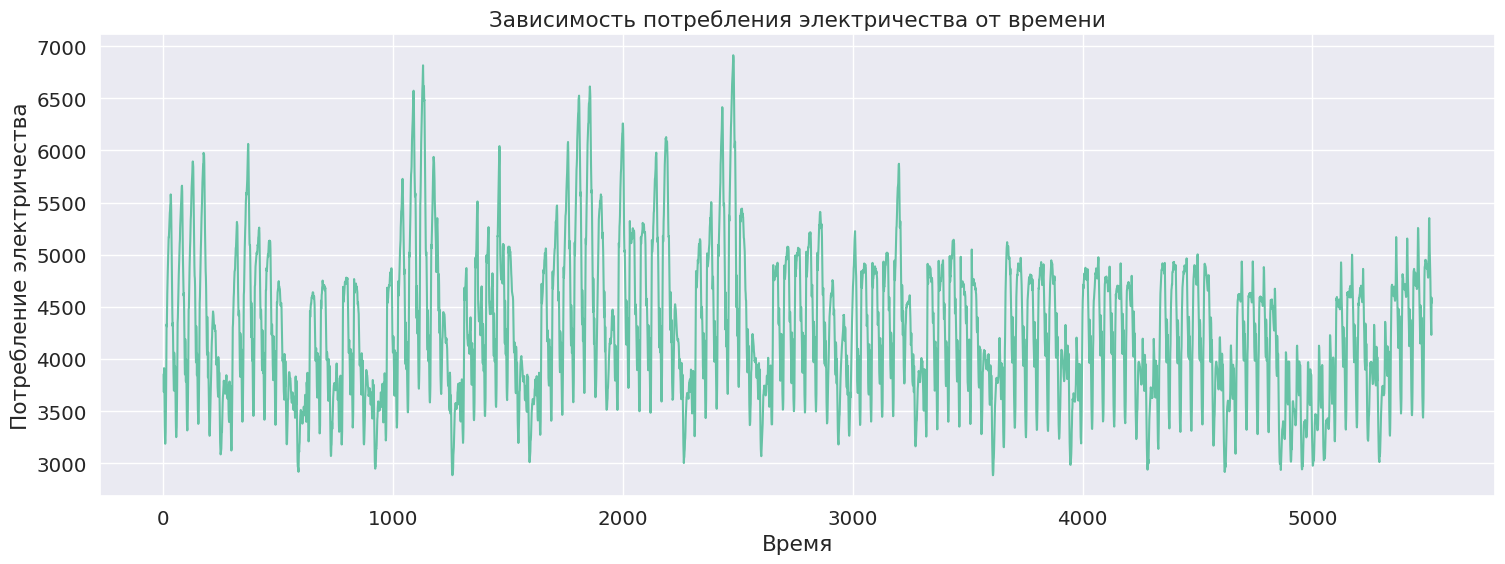

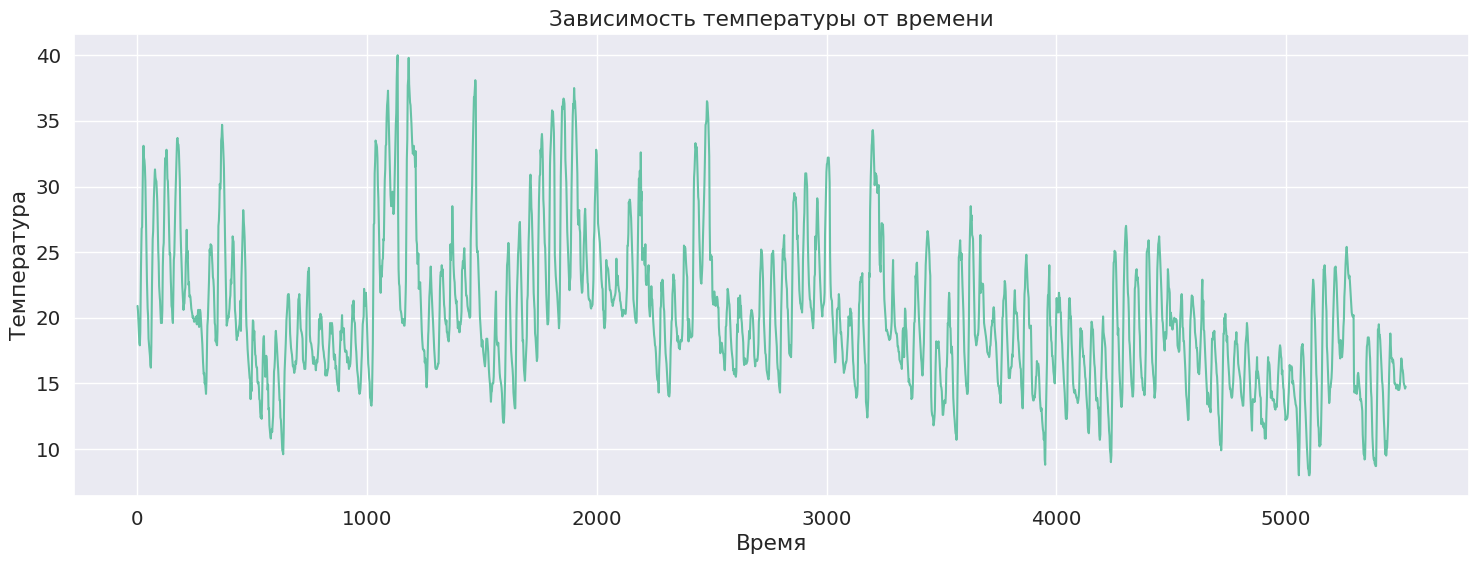

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(df.index, df.Consumption)
plt.xlabel("Время")
plt.ylabel("Потребление электричества")
plt.title("Зависимость потребления электричества от времени")
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(df.index, df.Temperature)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.title("Зависимость температуры от времени")
plt.show()

In [ ]:
train_data = df[["Consumption", "Temperature"]][: -48 * 14]
test_data = df[["Consumption", "Temperature"]][-48 * 14 :]

train_data.head()

,Consumption,Temperature
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60


Нормализуем данные:

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

train_data_normalized

array([[-0.51917527, -0.22435897],
       [-0.60383278, -0.23717949],
       [-0.48994882, -0.25      ],
       ...,
       [-0.52735753, -0.70833333],
       [-0.33621092, -0.73717949],
       [-0.35531061, -0.76923077]])

Создадим датасеты для обучения и валидации:

In [ ]:
class TSDataset(Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return (
            self.data[index : self.n_past + index],
            self.data[self.n_past + index],
        )

In [ ]:
n_past = 48  # tau -- длина отрезка временого ряда
batch_size = 16  # размер батча

full_train_dataset = TSDataset(train_data_normalized, n_past)
generator = torch.Generator().manual_seed(0)
train_dataset, validation_dataset = random_split(full_train_dataset, lengths=[0.8, 0.2], generator=generator)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=True)
validation_batch_gen = DataLoader(validation_dataset, batch_size, shuffle=False)

##Вспомогательные функции:

In [ ]:
def set_seed(seed: int):
    """Зафиксировать случайность.

    :param seed: int
        Инициализирующее значение
    """
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
def count_trainable_parameters(model):
    """Посчитать количество обучаемых параметров модели.

    :return: результат подсчета
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def plot_learning_curves(history):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["validation_loss"], label="validation")
    plt.yscale("log")
    plt.ylabel("Лосс")
    plt.xlabel("Эпоха")
    plt.legend()
    plt.show()


def evaluate_ts_model(model, start_seq, test_data):
    """
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.

    :return: результаты предсказания.
    """
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    model.train(False)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    return result


def plot_ts_results(result, show_from=0, lw=2):
    """
    Визуализирует результаты прогнозирования

    :param result: прогнозы
    :param show_from: с какого момента визуализировать обучающие данные
    :param lw: толщина линии
    """
    fontsize = 16
    plt.figure(figsize=(18, 8))
    plt.title("Зависимость потребления электричества от времени")
    plt.plot(
        df.index[show_from:], df.Consumption[show_from:], label="Истина", lw=lw
    )

    plt.plot(df.index[-48 * 14 :], result[:, 0], label="Предсказание", lw=lw)

    plt.xlabel("Время")
    plt.ylabel("Потребление электричества")
    plt.legend()
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    validation_batch_gen,
    num_epochs=50,
    show_plt = True,
    clear_out = False,
):
    """
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param validation_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    """

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        validation_loss = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type("torch.FloatTensor").to(device)
            y_batch = y_batch.type("torch.FloatTensor").to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history["train_loss"].append(train_loss)

        # Устанавливаем поведение dropout / batch_norm  в инференс
        model.train(False)

        # На каждой 'эпохе' делаем оценку качества на валидации
        with torch.no_grad():
            for X_batch, y_batch in validation_batch_gen:
                X_batch = X_batch.type("torch.FloatTensor").to(device)
                y_batch = y_batch.type("torch.FloatTensor").to(device)

                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                validation_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        validation_loss /= len(validation_batch_gen)
        history["validation_loss"].append(validation_loss)

        if clear_out:
          clear_output()

        # Печатаем результаты после каждой эпохи
        print(
            "Эпоха {} из {} выполнена за {:.3f} сек.".format(
                epoch + 1, num_epochs, time.time() - start_time
            )
        )
        print("  train loss: \t{:.6f}".format(train_loss))
        print("  validation loss: \t{:.6f}".format(validation_loss))
        if show_plt:
          plot_learning_curves(history)

    return model, history

def calculate_metrics(true_values, predicted_values):
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))
    mae = np.mean(np.abs(true_values - predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return rmse, mae, mape

## .

Построим модель по обучающей части данных

Возьмем RNN, в качетсве модели будет LSTM:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        self.out_net = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=self.output_size),
        )

    def forward(self, input_seq):
        # input_seq.shape = [batch_size, 2, 48]

        # lstm_out.shape = [batch_size, 48, hidden_size]
        # hidden_state.shape = [1, batch_size, hidden_size]
        lstm_out, (hidden_state, _) = self.lstm(input_seq)

        # predictions.shape = [batch_size, 2]
        predictions = self.out_net(hidden_state.squeeze(0))
        return predictions

Объявляем модель:

In [ ]:
set_seed(0)
lstm_model = LSTM(input_size=2, output_size=2, hidden_size=128)
print(f"Число обучаемых параметров: {count_trainable_parameters(lstm_model)}")
lstm_model.to(device)

Число обучаемых параметров: 67842


LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (out_net): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)

Обучим модель:

Эпоха 100 из 100 выполнена за 4.253 сек.
  train loss: 	0.000461
  validation loss: 	0.000600


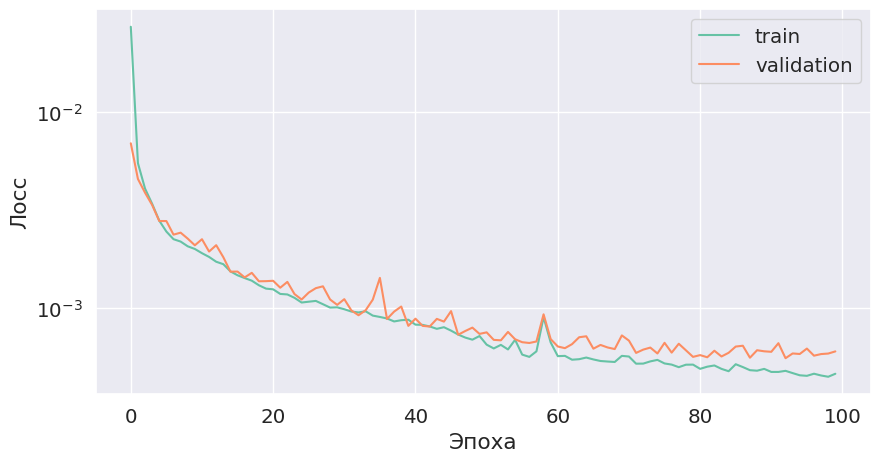

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)

lstm_model, _ = train_ts_model(
    lstm_model, criterion, optimizer, train_batch_gen, validation_batch_gen, num_epochs=100, clear_out = True
);

In [ ]:
start_seq = train_data_normalized[-n_past:]
lstm_result = evaluate_ts_model(lstm_model, start_seq, test_data_normalized)

In [ ]:
lstm_result = np.array(lstm_result, ndmin=2)
lstm_result = scaler.inverse_transform(lstm_result)

In [ ]:
y_truth = test_data["Consumption"]
rmse = np.sqrt(((lstm_result[:, 0] - y_truth) ** 2).mean())
print("RMSE на тестовых данных = {:.3f}".format(rmse))

RMSE на тестовых данных = 635.381


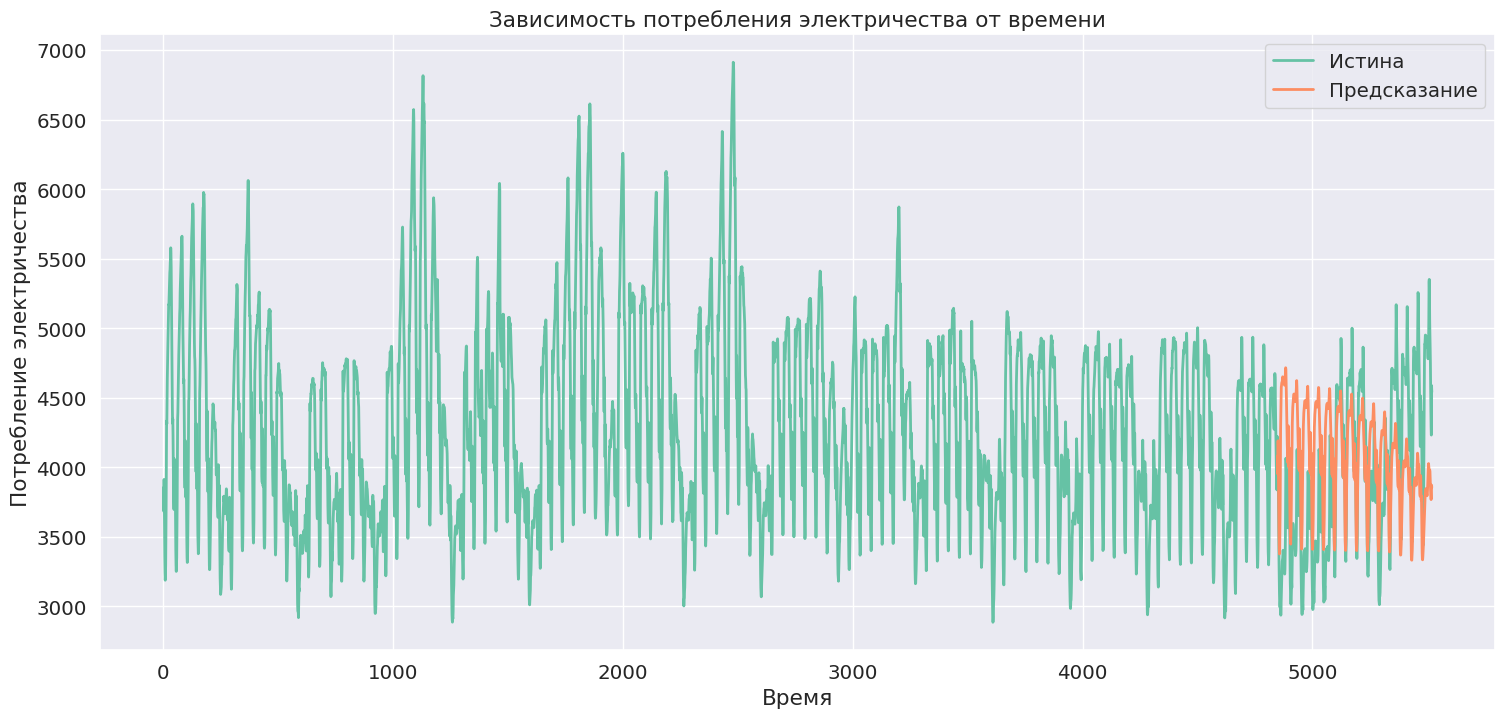

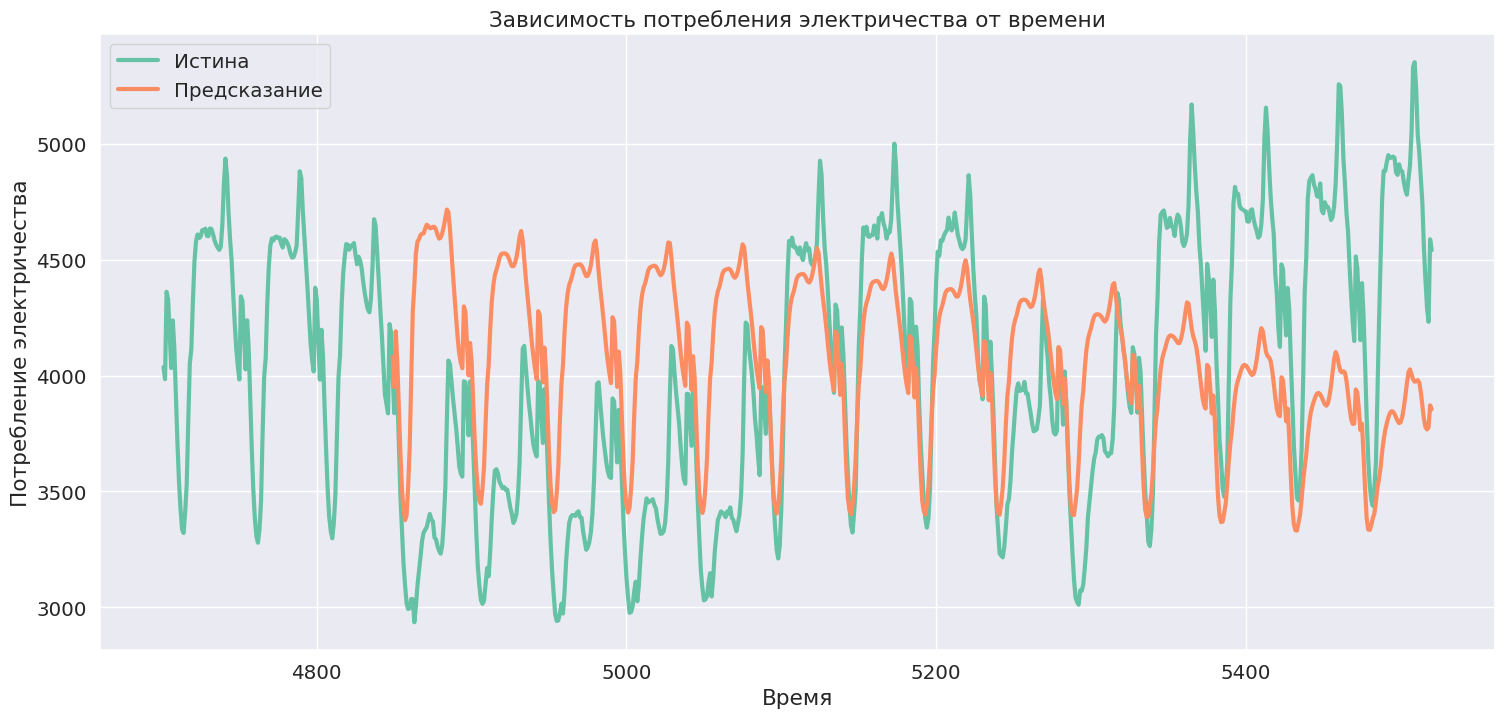

In [ ]:
plot_ts_results(lstm_result)
plot_ts_results(lstm_result, show_from= 4700, lw=3)

Зафиксируем некоторые константы:
* $h = 48\times7\ измерений = 7\ суток$ &mdash; горизонт прогнозирования;
* $\tau = 24\ измерения = 12\ часов$ &mdash; периодичность дообучения.

Теперь обсудим как должна выглядеть процедура дообучения. Пусть мы находимся в момент времени $T$ и уже обучили модель на всех имеющихся данных до момента времени $T$. Тогда необходимо выполнить следующие шаги.
1. Построить прогнозы на $h$ измерений вперед по одному наблюдению рекурсивно.
2. Подождать, пока поступят следующие $\tau$ измерений, и добавить их к обучающей выборке.
3. При необходимости удалить из обучающей выборки несколько старых измерений.
4. Произвести несколько итераций backpropagation для имеющейся нейронной сети и вернуться к шагу 1.

Зафиксируем константы:

In [ ]:
h = 48 * 7
n_past = 48
tau = 24

Объявим модель:

In [ ]:
input_size = 2
output_size = 2
hidden_size = 64

model = LSTM(input_size, output_size, hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Обучение модели на обучающей выборке:

Эпоха 100 из 100 выполнена за 2.197 сек.
  train loss: 	0.000474
  validation loss: 	0.000635


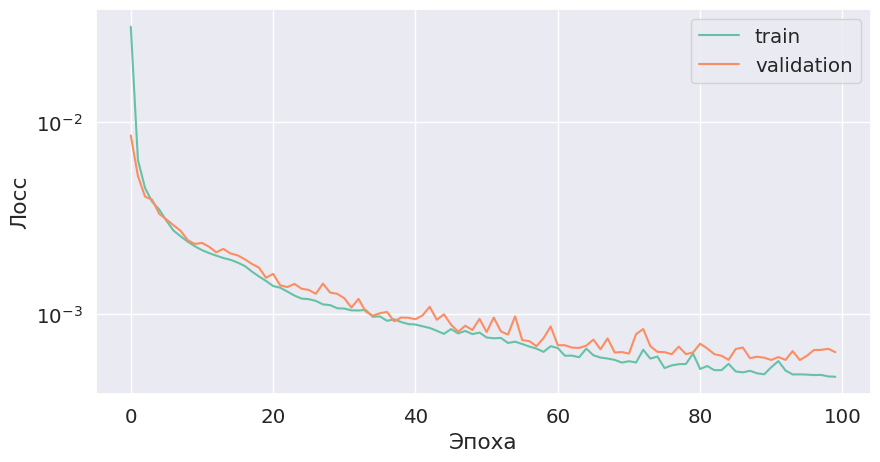

In [ ]:
model, history = train_ts_model(
    model, criterion, optimizer, train_batch_gen, validation_batch_gen, num_epochs=100, clear_out = True
)

Результат модели, обученной на train выборке:

In [ ]:
start_seq = train_data_normalized[-n_past:]
lstm_result = evaluate_ts_model(model, start_seq, test_data_normalized)
lstm_result = np.array(lstm_result, ndmin=2)
lstm_result = scaler.inverse_transform(lstm_result)
y_truth = test_data["Consumption"]
rmse = np.sqrt(((lstm_result[:, 0] - y_truth) ** 2).mean())
print("RMSE на тестовых данных = {:.3f}".format(rmse))

RMSE на тестовых данных = 739.464


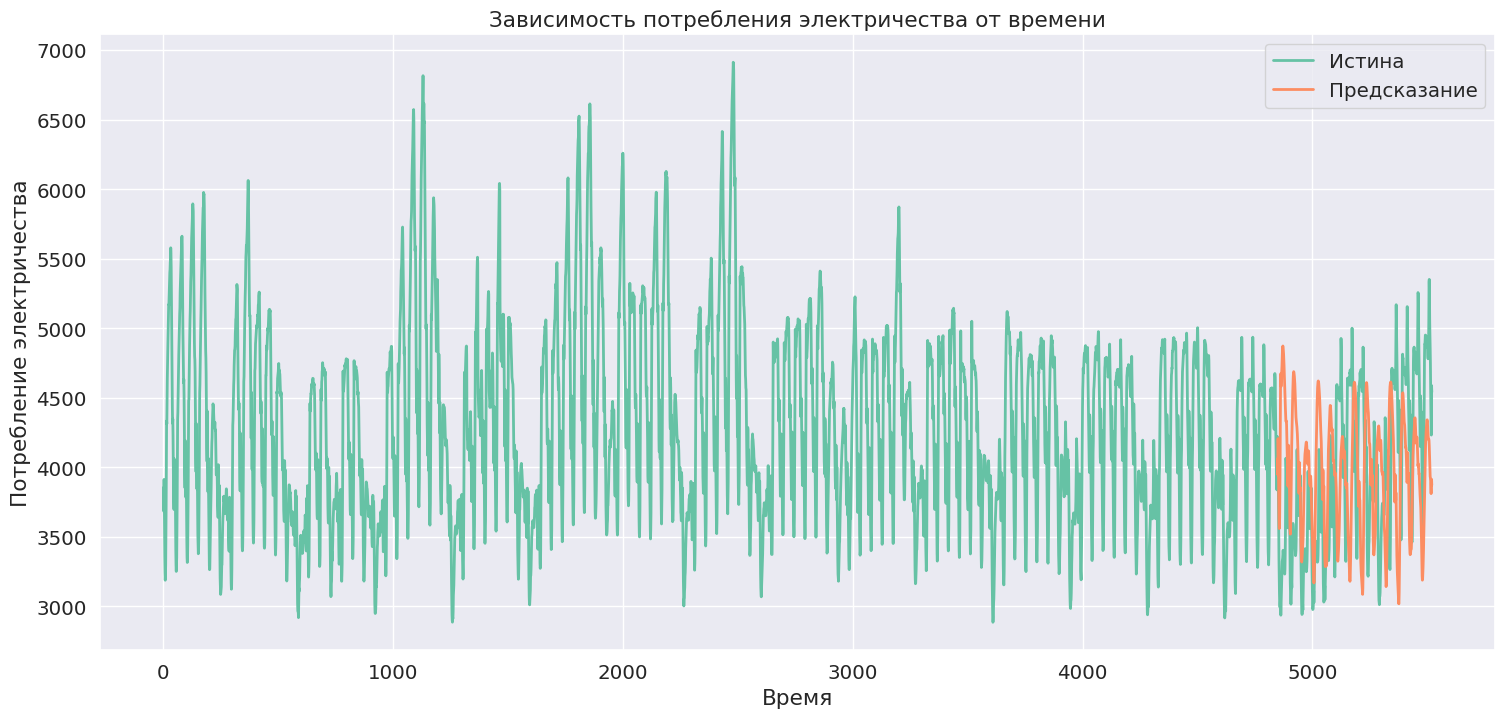

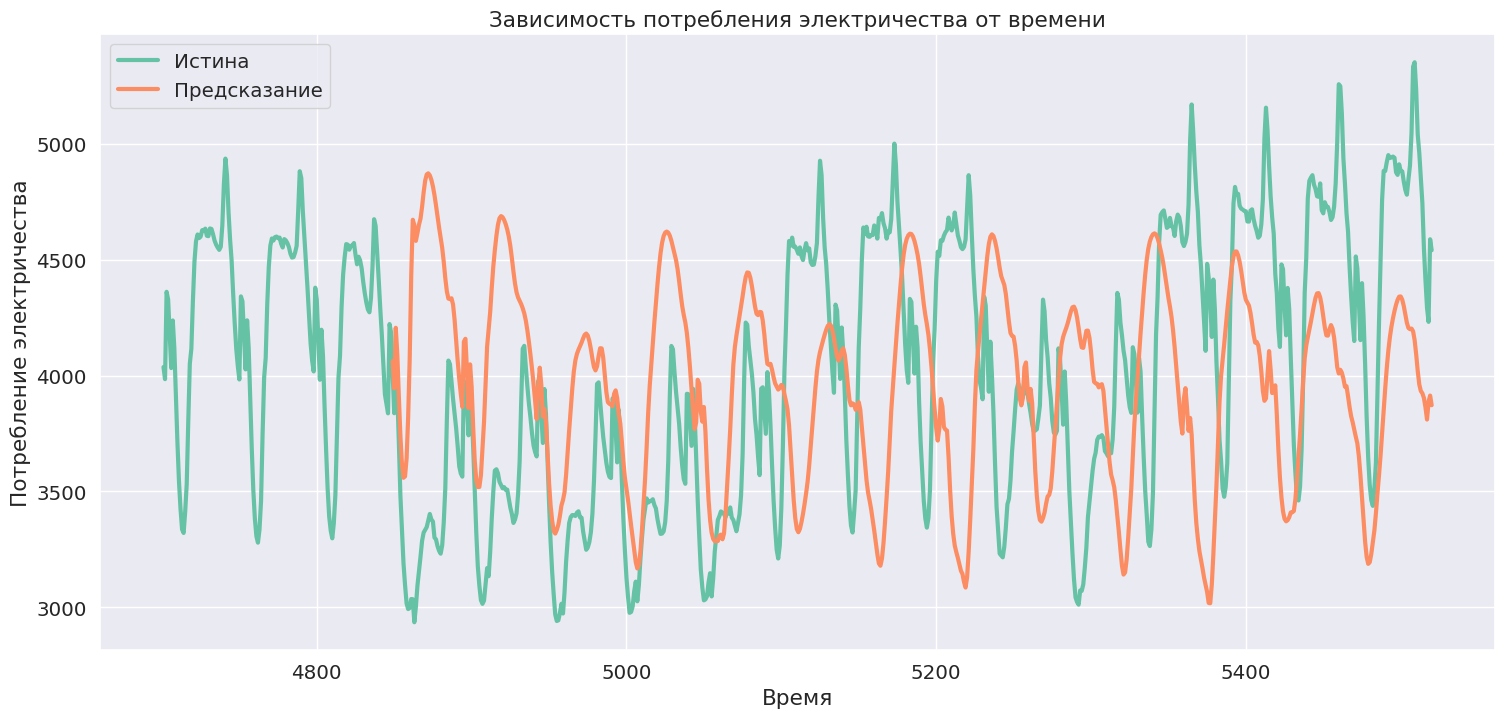

In [ ]:
plot_ts_results(lstm_result)
plot_ts_results(lstm_result, show_from= 4700, lw=3)

Дообучение модели в онлайн-режиме:

In [ ]:
def online_learning(model, train_data, test_data, h, tau, num_iterations=10):
    train_data = train_data.copy()
    test_data = test_data.copy()

    history_metrics = defaultdict(list)

    for iteration in range(num_iterations):
        # clear_output(wait=True)

        start_seq = train_data[-n_past:]
        predictions = evaluate_ts_model(model, start_seq, test_data[:h])
        predictions = np.array(predictions)

        plt.figure(figsize=(18, 8))
        plt.title(f"Итерация дообучения {iteration + 1}")
        plt.plot(df.index[:len(train_data)], train_data[:, 0], label="Обучающие данные", lw=2)
        plt.plot(df.index[len(train_data):len(train_data) + h], test_data[:h, 0], label="Тестовые данные", lw=2)
        plt.plot(df.index[len(train_data):len(train_data) + h], predictions[:, 0], label="Прогноз", lw=2)
        plt.axvline(x=len(train_data), color='r', linestyle='--', label="Текущий момент")
        plt.xlabel("Время")
        plt.ylabel("Потребление электричества")
        plt.legend()
        plt.show()

        rmse_h, mae_h, mape_h = calculate_metrics(test_data[:h, 0], predictions[:, 0])
        rmse_tau, mae_tau, mape_tau = calculate_metrics(test_data[:tau, 0], predictions[:tau, 0])

        history_metrics['rmse_h'].append(rmse_h)
        history_metrics['mae_h'].append(mae_h)
        history_metrics['mape_h'].append(mape_h)
        history_metrics['rmse_tau'].append(rmse_tau)
        history_metrics['mae_tau'].append(mae_tau)
        history_metrics['mape_tau'].append(mape_tau)

        print(f"Итерация {iteration + 1}:")
        print(f"  RMSE на горизонте h: {rmse_h:.4f}")
        print(f"  MAE на горизонте h: {mae_h:.4f}")
        print(f"  MAPE на горизонте h: {mape_h:.4f}")
        print(f"  RMSE на горизонте tau: {rmse_tau:.4f}")
        print(f"  MAE на горизонте tau: {mae_tau:.4f}")
        print(f"  MAPE на горизонте tau: {mape_tau:.4f}")

        train_data = np.concatenate([train_data, test_data[:tau]], axis=0)
        test_data = test_data[tau:]

        if len(train_data) > n_past + h:
            train_data = train_data[-(n_past + h):]

        train_dataset = TSDataset(train_data, n_past)
        train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=True)

        model, _ = train_ts_model(
            model, criterion, optimizer, train_batch_gen, validation_batch_gen, num_epochs=25, show_plt = False
        )

        time.sleep(1)

    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle("Изменение ошибок при дообучении", fontsize=16)

    axes[0, 0].plot(history_metrics['rmse_h'], label="RMSE на горизонте h", color='blue')
    axes[0, 0].set_title("RMSE на горизонте h")
    axes[0, 0].set_xlabel("Итерация дообучения")
    axes[0, 0].set_ylabel("Ошибка")
    axes[0, 0].legend()

    axes[0, 1].plot(history_metrics['mae_h'], label="MAE на горизонте h", color='orange')
    axes[0, 1].set_title("MAE на горизонте h")
    axes[0, 1].set_xlabel("Итерация дообучения")
    axes[0, 1].set_ylabel("Ошибка")
    axes[0, 1].legend()

    axes[1, 0].plot(history_metrics['mape_h'], label="MAPE на горизонте h", color='green')
    axes[1, 0].set_title("MAPE на горизонте h")
    axes[1, 0].set_xlabel("Итерация дообучения")
    axes[1, 0].set_ylabel("Ошибка")
    axes[1, 0].legend()

    axes[1, 1].plot(history_metrics['rmse_tau'], label="RMSE на горизонте tau", color='red')
    axes[1, 1].set_title("RMSE на горизонте tau")
    axes[1, 1].set_xlabel("Итерация дообучения")
    axes[1, 1].set_ylabel("Ошибка")
    axes[1, 1].legend()

    axes[2, 0].plot(history_metrics['mae_tau'], label="MAE на горизонте tau", color='purple')
    axes[2, 0].set_title("MAE на горизонте tau")
    axes[2, 0].set_xlabel("Итерация дообучения")
    axes[2, 0].set_ylabel("Ошибка")
    axes[2, 0].legend()

    axes[2, 1].plot(history_metrics['mape_tau'], label="MAPE на горизонте tau", color='brown')
    axes[2, 1].set_title("MAPE на горизонте tau")
    axes[2, 1].set_xlabel("Итерация дообучения")
    axes[2, 1].set_ylabel("Ошибка")
    axes[2, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

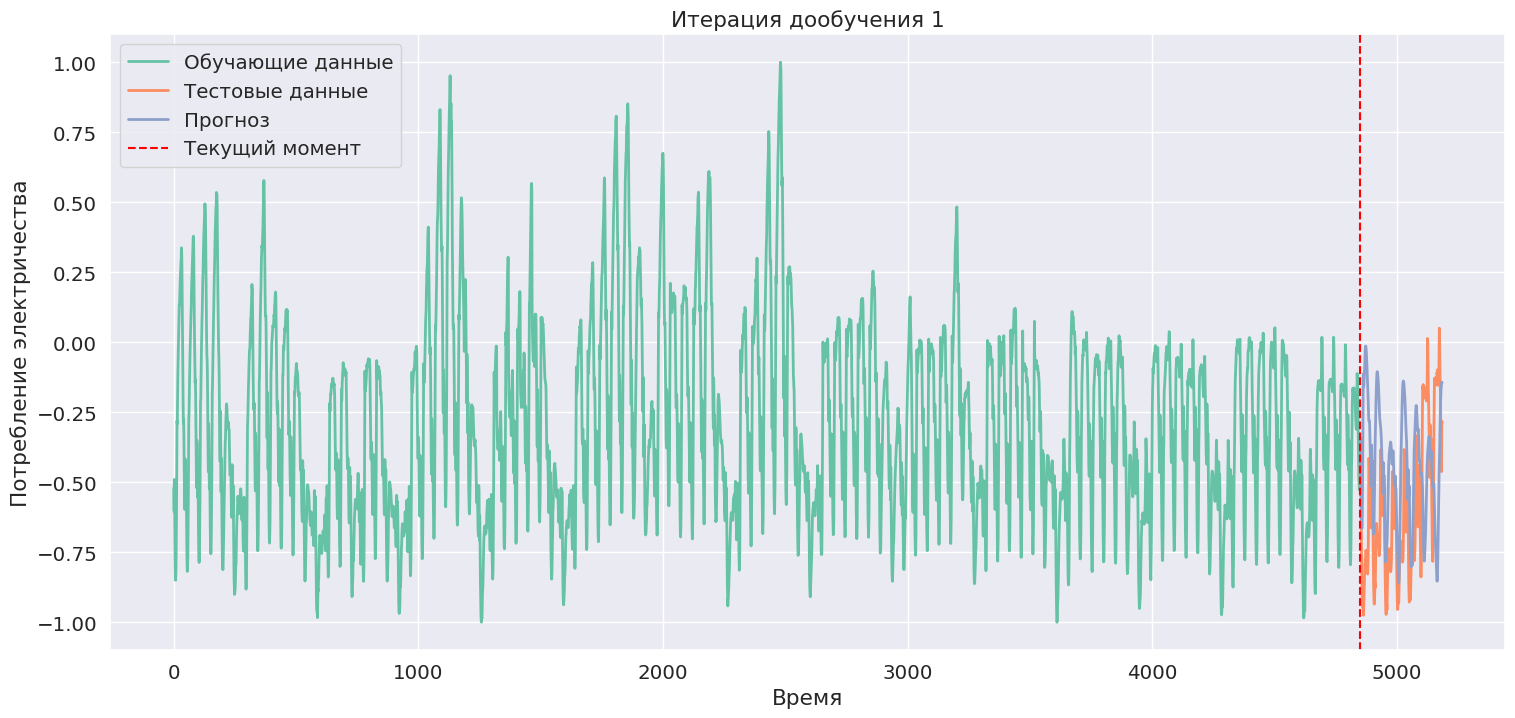

Итерация 1:
  RMSE на горизонте h: 0.3622
  MAE на горизонте h: 0.2928
  MAPE на горизонте h: 123.0950
  RMSE на горизонте tau: 0.5608
  MAE на горизонте tau: 0.4720
  MAPE на горизонте tau: 56.2400
Эпоха 1 из 25 выполнена за 0.331 сек.
  train loss: 	0.000300
  validation loss: 	0.000606
Эпоха 2 из 25 выполнена за 0.305 сек.
  train loss: 	0.000232
  validation loss: 	0.000593
Эпоха 3 из 25 выполнена за 0.301 сек.
  train loss: 	0.000235
  validation loss: 	0.000581
Эпоха 4 из 25 выполнена за 0.311 сек.
  train loss: 	0.000217
  validation loss: 	0.000617
Эпоха 5 из 25 выполнена за 0.312 сек.
  train loss: 	0.000216
  validation loss: 	0.000597
Эпоха 6 из 25 выполнена за 0.310 сек.
  train loss: 	0.000207
  validation loss: 	0.000593
Эпоха 7 из 25 выполнена за 0.298 сек.
  train loss: 	0.000220
  validation loss: 	0.000621
Эпоха 8 из 25 выполнена за 0.315 сек.
  train loss: 	0.000207
  validation loss: 	0.000618
Эпоха 9 из 25 выполнена за 0.302 сек.
  train loss: 	0.000194
  validatio

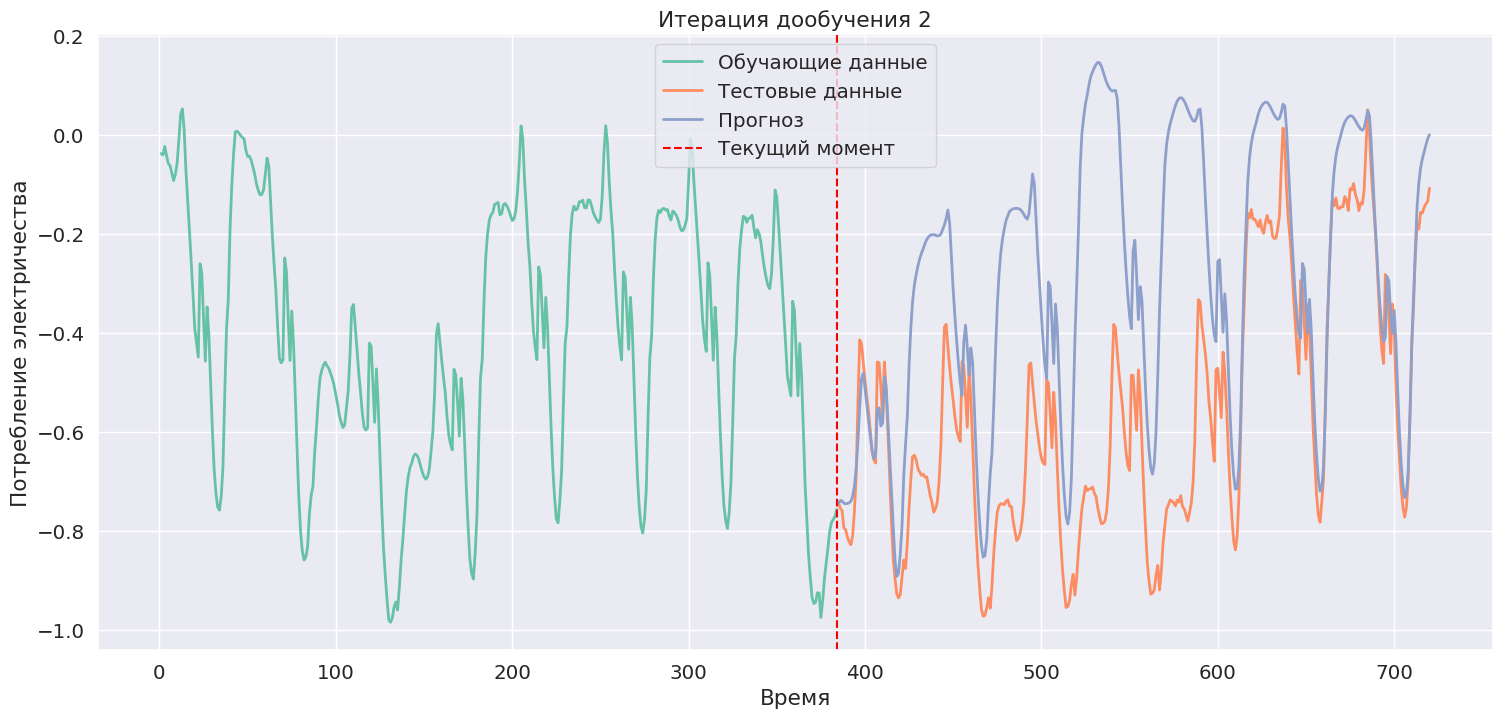

Итерация 2:
  RMSE на горизонте h: 0.3680
  MAE на горизонте h: 0.2713
  MAPE на горизонте h: 57.6374
  RMSE на горизонте tau: 0.0585
  MAE на горизонте tau: 0.0456
  MAPE на горизонте tau: 7.8759
Эпоха 1 из 25 выполнена за 0.320 сек.
  train loss: 	0.000300
  validation loss: 	0.000778
Эпоха 2 из 25 выполнена за 0.326 сек.
  train loss: 	0.000227
  validation loss: 	0.000710
Эпоха 3 из 25 выполнена за 0.311 сек.
  train loss: 	0.000246
  validation loss: 	0.000810
Эпоха 4 из 25 выполнена за 0.312 сек.
  train loss: 	0.000234
  validation loss: 	0.000713
Эпоха 5 из 25 выполнена за 0.324 сек.
  train loss: 	0.000197
  validation loss: 	0.000705
Эпоха 6 из 25 выполнена за 0.302 сек.
  train loss: 	0.000186
  validation loss: 	0.000722
Эпоха 7 из 25 выполнена за 0.305 сек.
  train loss: 	0.000164
  validation loss: 	0.000729
Эпоха 8 из 25 выполнена за 0.324 сек.
  train loss: 	0.000166
  validation loss: 	0.000702
Эпоха 9 из 25 выполнена за 0.300 сек.
  train loss: 	0.000163
  validation 

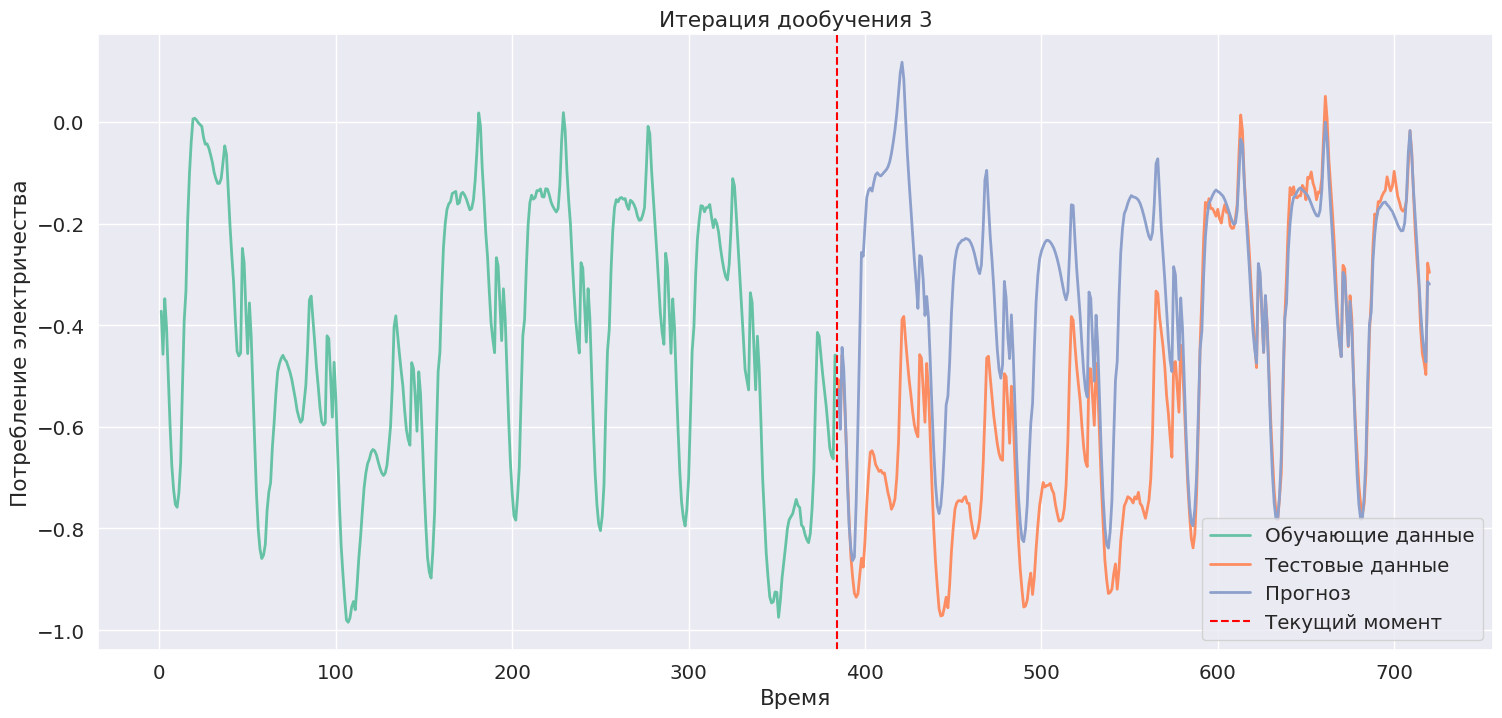

Итерация 3:
  RMSE на горизонте h: 0.3005
  MAE на горизонте h: 0.2090
  MAPE на горизонте h: 39.2170
  RMSE на горизонте tau: 0.4079
  MAE на горизонте tau: 0.3138
  MAPE на горизонте tau: 42.3042
Эпоха 1 из 25 выполнена за 0.325 сек.
  train loss: 	0.000192
  validation loss: 	0.000908
Эпоха 2 из 25 выполнена за 0.307 сек.
  train loss: 	0.000166
  validation loss: 	0.000884
Эпоха 3 из 25 выполнена за 0.301 сек.
  train loss: 	0.000163
  validation loss: 	0.000840
Эпоха 4 из 25 выполнена за 0.315 сек.
  train loss: 	0.000174
  validation loss: 	0.000746
Эпоха 5 из 25 выполнена за 0.301 сек.
  train loss: 	0.000169
  validation loss: 	0.000853
Эпоха 6 из 25 выполнена за 0.309 сек.
  train loss: 	0.000176
  validation loss: 	0.000875
Эпоха 7 из 25 выполнена за 0.323 сек.
  train loss: 	0.000162
  validation loss: 	0.000933
Эпоха 8 из 25 выполнена за 0.307 сек.
  train loss: 	0.000146
  validation loss: 	0.000923
Эпоха 9 из 25 выполнена за 0.308 сек.
  train loss: 	0.000148
  validation

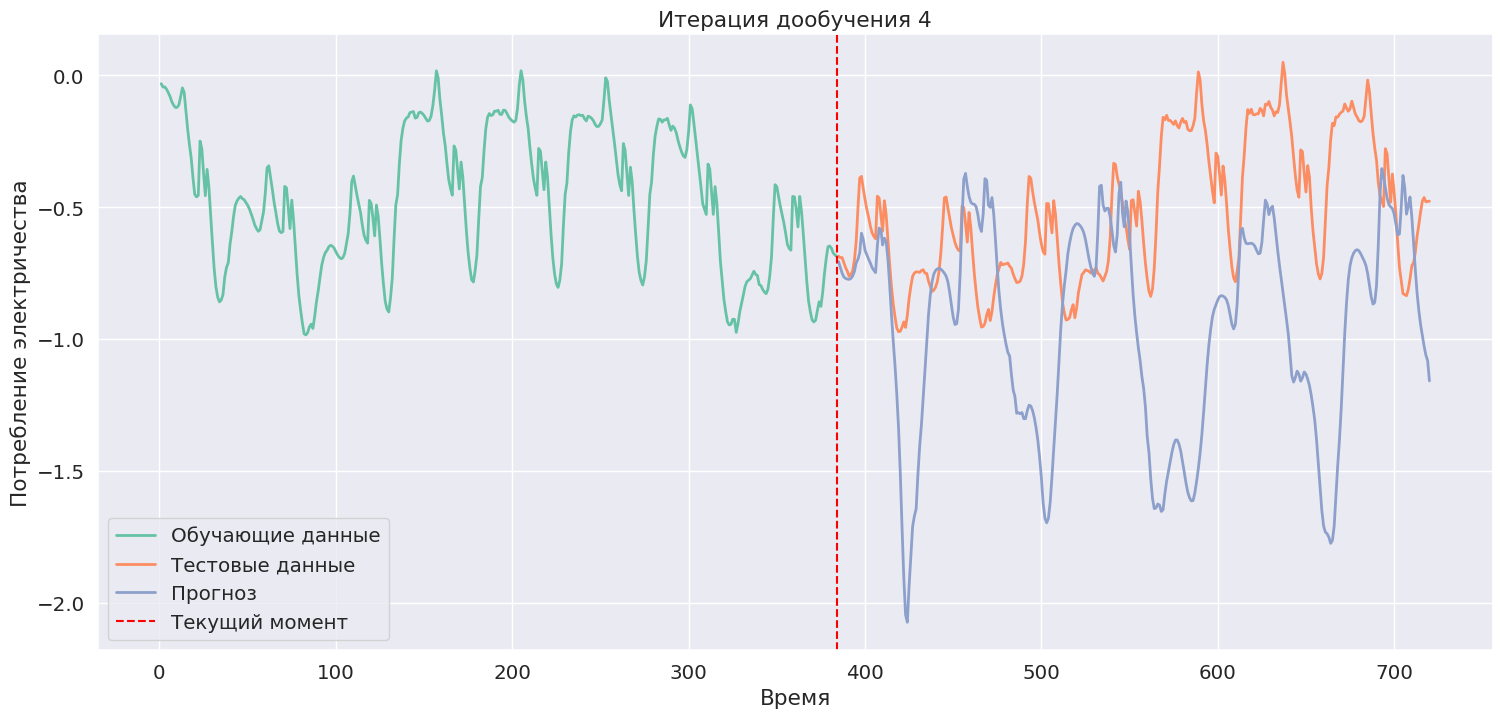

Итерация 4:
  RMSE на горизонте h: 0.6540
  MAE на горизонте h: 0.5130
  MAPE на горизонте h: 318.6238
  RMSE на горизонте tau: 0.1343
  MAE на горизонте tau: 0.1106
  MAPE на горизонте tau: 22.1359
Эпоха 1 из 25 выполнена за 0.493 сек.
  train loss: 	0.000219
  validation loss: 	0.000875
Эпоха 2 из 25 выполнена за 0.469 сек.
  train loss: 	0.000399
  validation loss: 	0.001008
Эпоха 3 из 25 выполнена за 0.510 сек.
  train loss: 	0.000420
  validation loss: 	0.000862
Эпоха 4 из 25 выполнена за 0.543 сек.
  train loss: 	0.000270
  validation loss: 	0.000810
Эпоха 5 из 25 выполнена за 0.501 сек.
  train loss: 	0.000223
  validation loss: 	0.000790
Эпоха 6 из 25 выполнена за 0.551 сек.
  train loss: 	0.000188
  validation loss: 	0.000815
Эпоха 7 из 25 выполнена за 0.482 сек.
  train loss: 	0.000154
  validation loss: 	0.000849
Эпоха 8 из 25 выполнена за 0.464 сек.
  train loss: 	0.000140
  validation loss: 	0.000886
Эпоха 9 из 25 выполнена за 0.441 сек.
  train loss: 	0.000154
  validatio

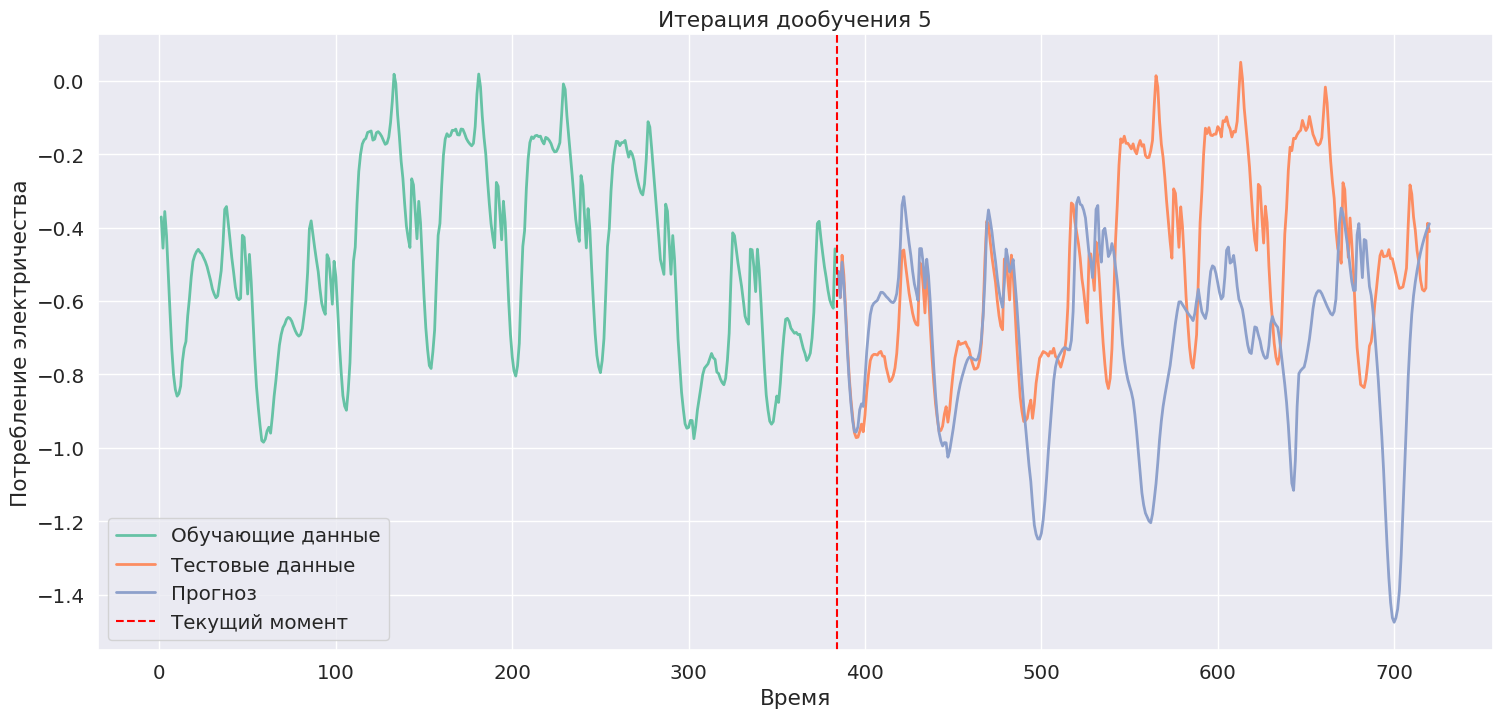

Итерация 5:
  RMSE на горизонте h: 0.3936
  MAE на горизонте h: 0.2863
  MAPE на горизонте h: 216.0769
  RMSE на горизонте tau: 0.0839
  MAE на горизонте tau: 0.0631
  MAPE на горизонте tau: 8.0751
Эпоха 1 из 25 выполнена за 0.344 сек.
  train loss: 	0.000107
  validation loss: 	0.001019
Эпоха 2 из 25 выполнена за 0.309 сек.
  train loss: 	0.000116
  validation loss: 	0.001094
Эпоха 3 из 25 выполнена за 0.312 сек.
  train loss: 	0.000100
  validation loss: 	0.001033
Эпоха 4 из 25 выполнена за 0.321 сек.
  train loss: 	0.000106
  validation loss: 	0.001078
Эпоха 5 из 25 выполнена за 0.323 сек.
  train loss: 	0.000110
  validation loss: 	0.001079
Эпоха 6 из 25 выполнена за 0.314 сек.
  train loss: 	0.000119
  validation loss: 	0.001081
Эпоха 7 из 25 выполнена за 0.312 сек.
  train loss: 	0.000108
  validation loss: 	0.001063
Эпоха 8 из 25 выполнена за 0.326 сек.
  train loss: 	0.000107
  validation loss: 	0.001229
Эпоха 9 из 25 выполнена за 0.392 сек.
  train loss: 	0.000104
  validation

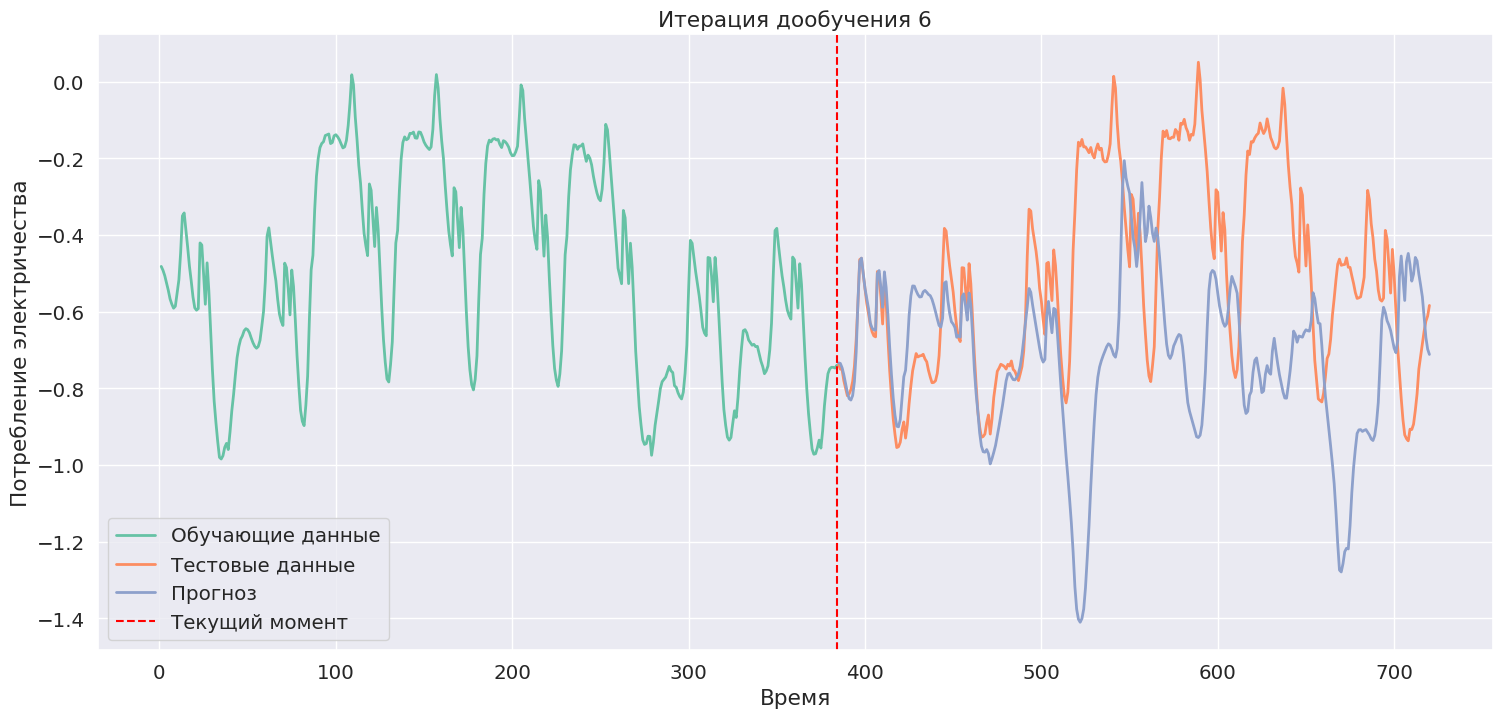

Итерация 6:
  RMSE на горизонте h: 0.4113
  MAE на горизонте h: 0.3004
  MAPE на горизонте h: 238.4511
  RMSE на горизонте tau: 0.0168
  MAE на горизонте tau: 0.0127
  MAPE на горизонте tau: 1.8228
Эпоха 1 из 25 выполнена за 0.349 сек.
  train loss: 	0.000096
  validation loss: 	0.001172
Эпоха 2 из 25 выполнена за 0.329 сек.
  train loss: 	0.000114
  validation loss: 	0.001157
Эпоха 3 из 25 выполнена за 0.327 сек.
  train loss: 	0.000108
  validation loss: 	0.001267
Эпоха 4 из 25 выполнена за 0.331 сек.
  train loss: 	0.000099
  validation loss: 	0.001296
Эпоха 5 из 25 выполнена за 0.340 сек.
  train loss: 	0.000097
  validation loss: 	0.001153
Эпоха 6 из 25 выполнена за 0.324 сек.
  train loss: 	0.000086
  validation loss: 	0.001226
Эпоха 7 из 25 выполнена за 0.333 сек.
  train loss: 	0.000088
  validation loss: 	0.001261
Эпоха 8 из 25 выполнена за 0.327 сек.
  train loss: 	0.000090
  validation loss: 	0.001246
Эпоха 9 из 25 выполнена за 0.322 сек.
  train loss: 	0.000085
  validation

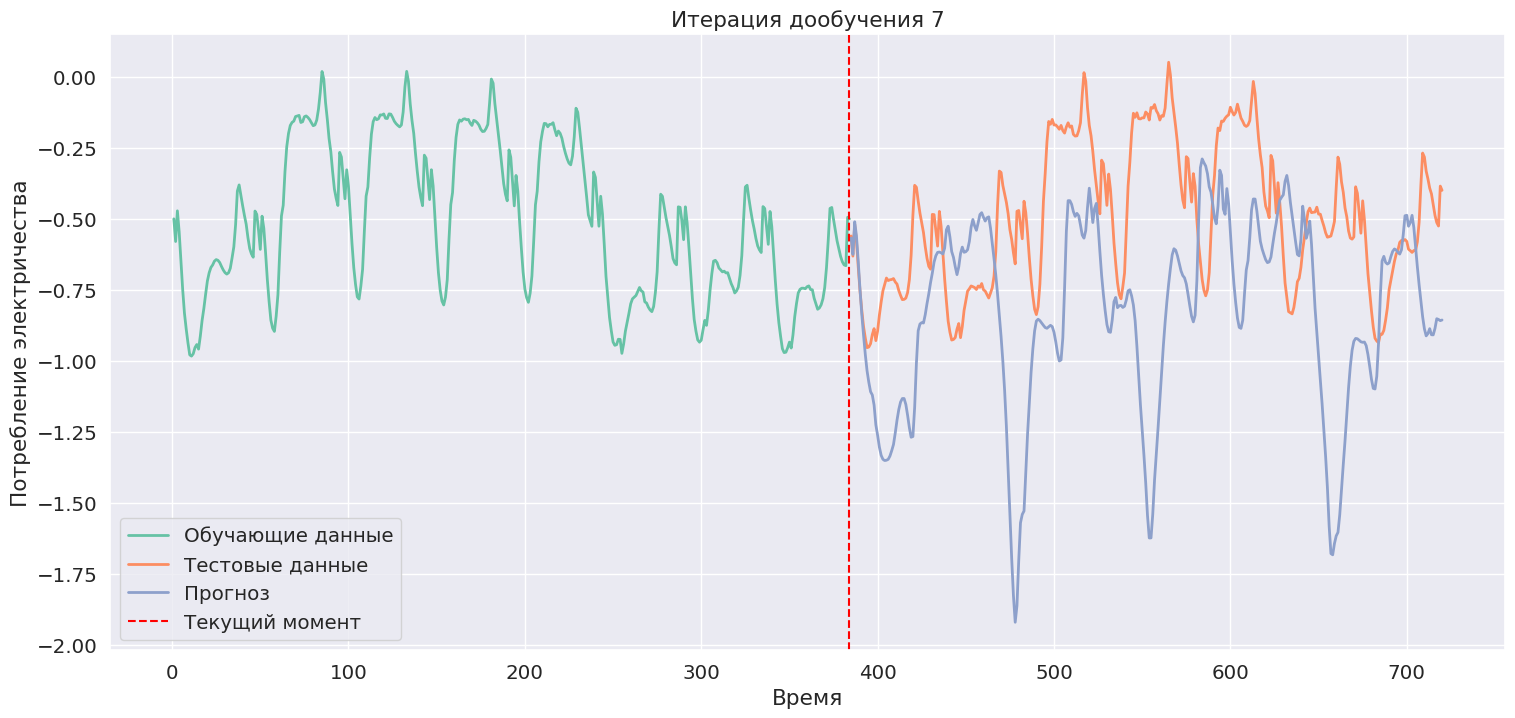

Итерация 7:
  RMSE на горизонте h: 0.5331
  MAE на горизонте h: 0.4207
  MAPE на горизонте h: 234.5530
  RMSE на горизонте tau: 0.3650
  MAE на горизонте tau: 0.2666
  MAPE на горизонте tau: 34.3173
Эпоха 1 из 25 выполнена за 0.383 сек.
  train loss: 	0.000136
  validation loss: 	0.001303
Эпоха 2 из 25 выполнена за 0.335 сек.
  train loss: 	0.000108
  validation loss: 	0.001296
Эпоха 3 из 25 выполнена за 0.326 сек.
  train loss: 	0.000104
  validation loss: 	0.001261
Эпоха 4 из 25 выполнена за 0.321 сек.
  train loss: 	0.000099
  validation loss: 	0.001285
Эпоха 5 из 25 выполнена за 0.322 сек.
  train loss: 	0.000109
  validation loss: 	0.001360
Эпоха 6 из 25 выполнена за 0.325 сек.
  train loss: 	0.000100
  validation loss: 	0.001292
Эпоха 7 из 25 выполнена за 0.329 сек.
  train loss: 	0.000107
  validation loss: 	0.001343
Эпоха 8 из 25 выполнена за 0.329 сек.
  train loss: 	0.000083
  validation loss: 	0.001326
Эпоха 9 из 25 выполнена за 0.324 сек.
  train loss: 	0.000093
  validatio

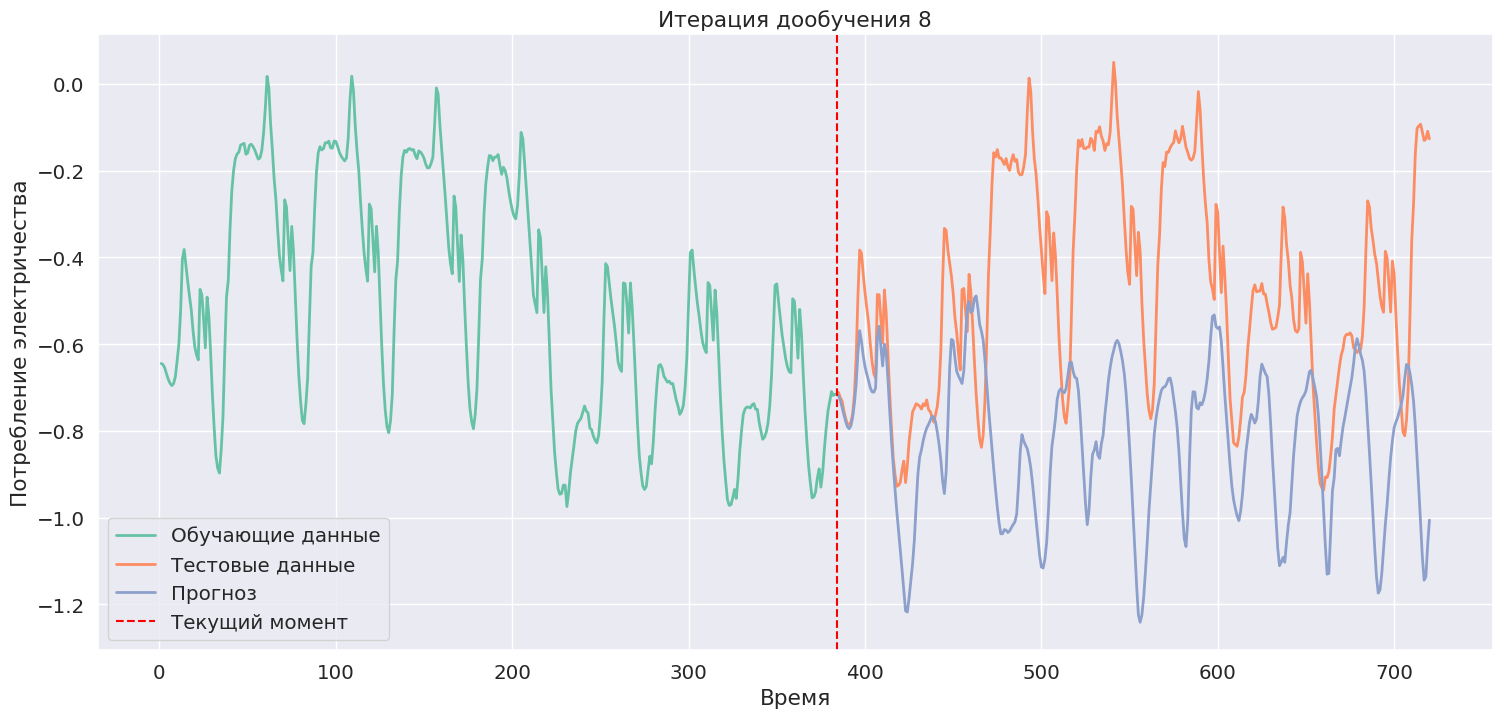

Итерация 8:
  RMSE на горизонте h: 0.4648
  MAE на горизонте h: 0.3684
  MAPE на горизонте h: 258.4620
  RMSE на горизонте tau: 0.0995
  MAE на горизонте tau: 0.0724
  MAPE на горизонте tau: 14.8594
Эпоха 1 из 25 выполнена за 0.352 сек.
  train loss: 	0.000107
  validation loss: 	0.001252
Эпоха 2 из 25 выполнена за 0.321 сек.
  train loss: 	0.000134
  validation loss: 	0.001230
Эпоха 3 из 25 выполнена за 0.332 сек.
  train loss: 	0.000128
  validation loss: 	0.001271
Эпоха 4 из 25 выполнена за 0.321 сек.
  train loss: 	0.000134
  validation loss: 	0.001327
Эпоха 5 из 25 выполнена за 0.322 сек.
  train loss: 	0.000138
  validation loss: 	0.001300
Эпоха 6 из 25 выполнена за 0.336 сек.
  train loss: 	0.000148
  validation loss: 	0.001224
Эпоха 7 из 25 выполнена за 0.339 сек.
  train loss: 	0.000141
  validation loss: 	0.001274
Эпоха 8 из 25 выполнена за 0.338 сек.
  train loss: 	0.000112
  validation loss: 	0.001206
Эпоха 9 из 25 выполнена за 0.327 сек.
  train loss: 	0.000114
  validatio

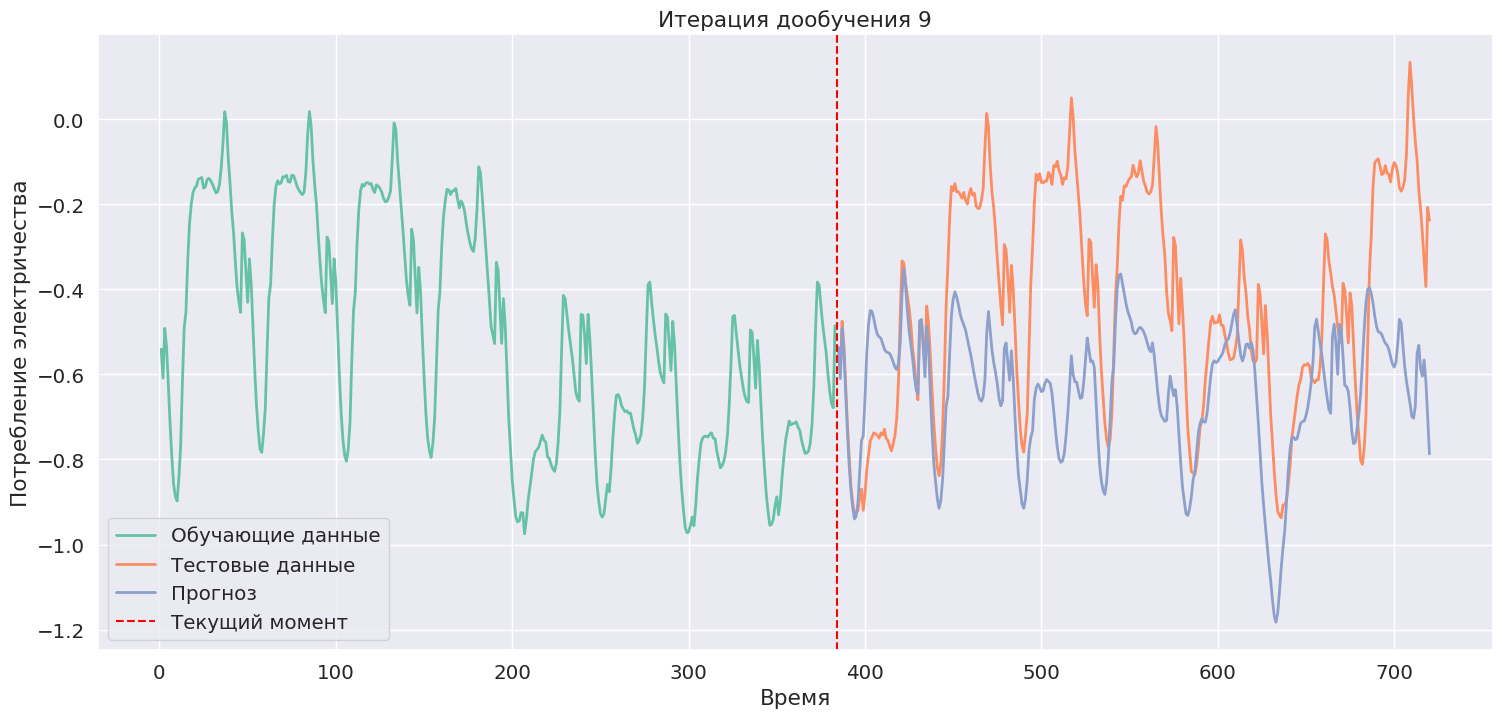

Итерация 9:
  RMSE на горизонте h: 0.3053
  MAE на горизонте h: 0.2462
  MAPE на горизонте h: 239.7930
  RMSE на горизонте tau: 0.1706
  MAE на горизонте tau: 0.1218
  MAPE на горизонте tau: 15.6542
Эпоха 1 из 25 выполнена за 0.558 сек.
  train loss: 	0.000123
  validation loss: 	0.001251
Эпоха 2 из 25 выполнена за 0.397 сек.
  train loss: 	0.000142
  validation loss: 	0.001288
Эпоха 3 из 25 выполнена за 0.374 сек.
  train loss: 	0.000113
  validation loss: 	0.001331
Эпоха 4 из 25 выполнена за 0.359 сек.
  train loss: 	0.000092
  validation loss: 	0.001316
Эпоха 5 из 25 выполнена за 0.324 сек.
  train loss: 	0.000098
  validation loss: 	0.001292
Эпоха 6 из 25 выполнена за 0.357 сек.
  train loss: 	0.000129
  validation loss: 	0.001278
Эпоха 7 из 25 выполнена за 0.334 сек.
  train loss: 	0.000138
  validation loss: 	0.001381
Эпоха 8 из 25 выполнена за 0.325 сек.
  train loss: 	0.000113
  validation loss: 	0.001410
Эпоха 9 из 25 выполнена за 0.348 сек.
  train loss: 	0.000095
  validatio

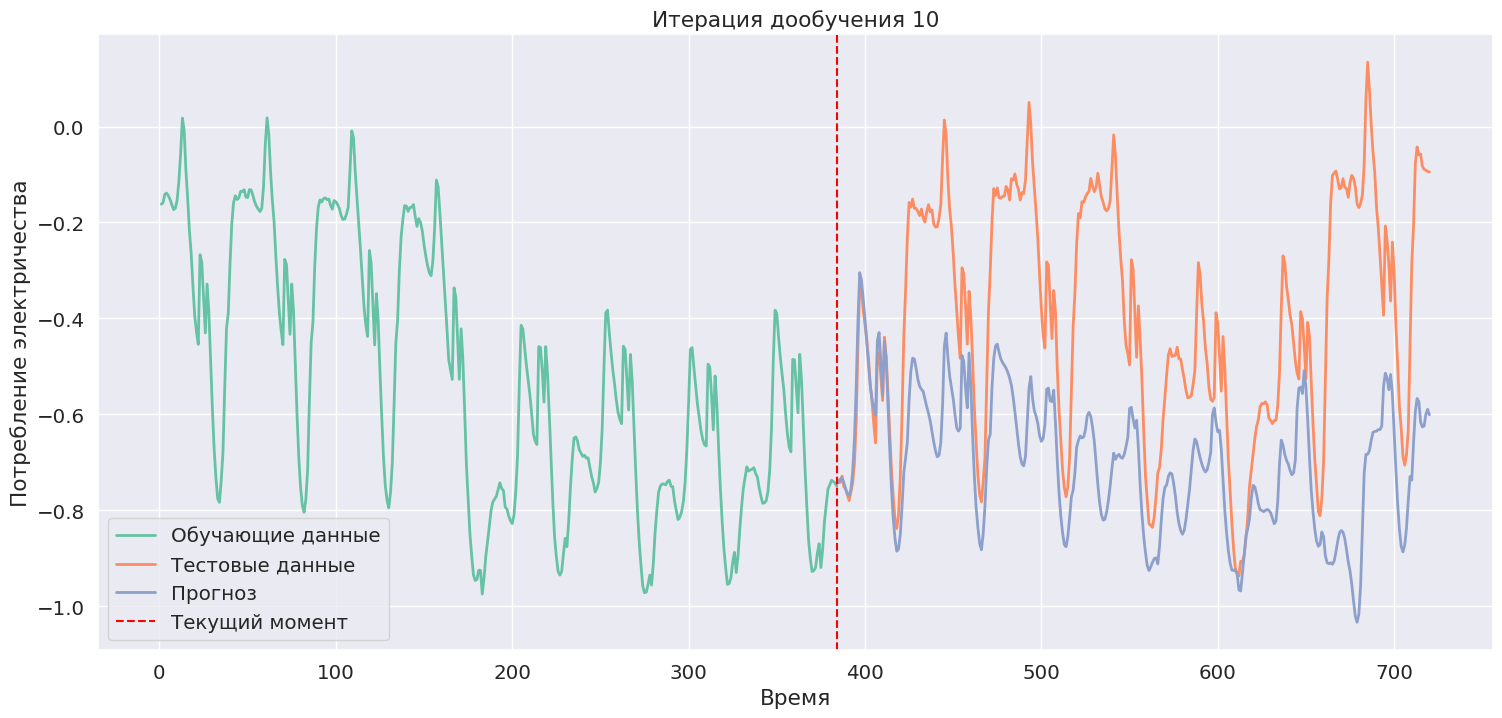

Итерация 10:
  RMSE на горизонте h: 0.3696
  MAE на горизонте h: 0.3004
  MAPE на горизонте h: 279.8601
  RMSE на горизонте tau: 0.0289
  MAE на горизонте tau: 0.0212
  MAPE на горизонте tau: 4.0033
Эпоха 1 из 25 выполнена за 0.373 сек.
  train loss: 	0.000106
  validation loss: 	0.001429
Эпоха 2 из 25 выполнена за 0.420 сек.
  train loss: 	0.000147
  validation loss: 	0.001382
Эпоха 3 из 25 выполнена за 0.455 сек.
  train loss: 	0.000138
  validation loss: 	0.001352
Эпоха 4 из 25 выполнена за 0.491 сек.
  train loss: 	0.000104
  validation loss: 	0.001430
Эпоха 5 из 25 выполнена за 0.471 сек.
  train loss: 	0.000147
  validation loss: 	0.001500
Эпоха 6 из 25 выполнена за 0.483 сек.
  train loss: 	0.000508
  validation loss: 	0.001443
Эпоха 7 из 25 выполнена за 0.442 сек.
  train loss: 	0.000427
  validation loss: 	0.001549
Эпоха 8 из 25 выполнена за 0.346 сек.
  train loss: 	0.000291
  validation loss: 	0.001300
Эпоха 9 из 25 выполнена за 0.321 сек.
  train loss: 	0.000203
  validatio

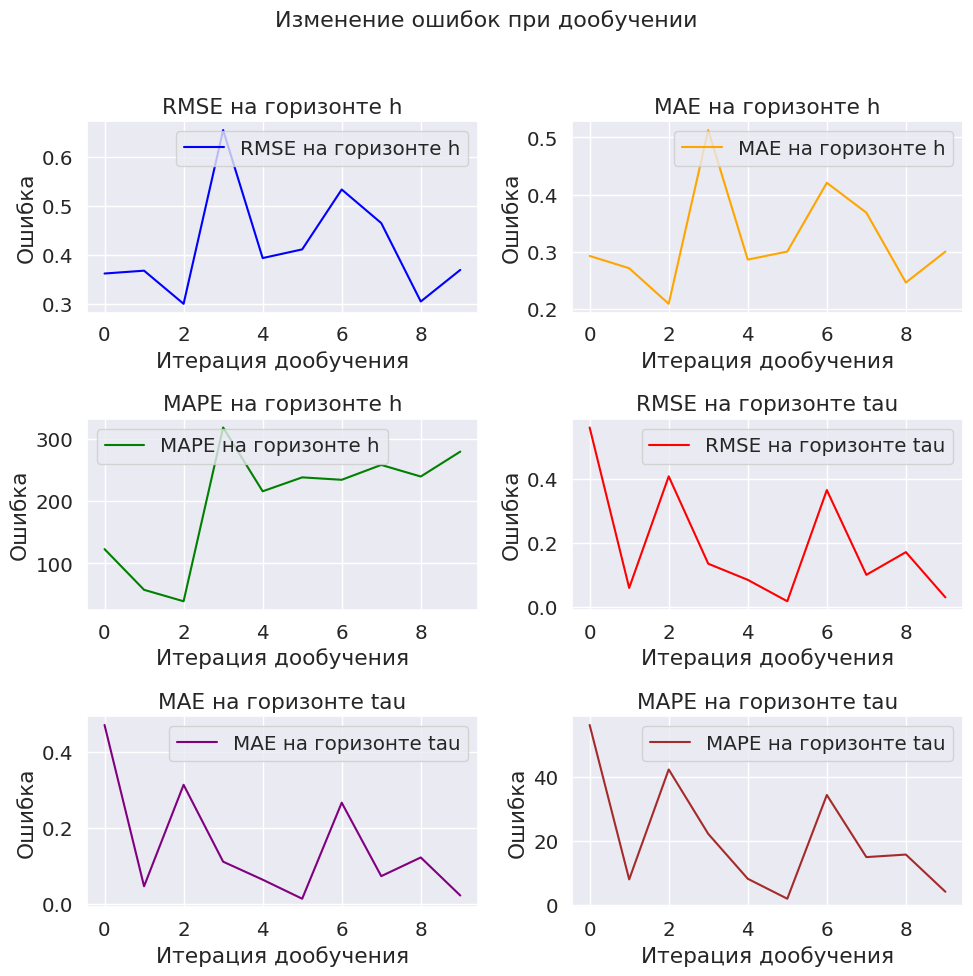

In [ ]:
online_learning(model, train_data_normalized, test_data_normalized, h, tau, num_iterations=10)

**Вывод:**
Была реализована и симулирована процедура онлайн-обучения нейросетевой модели временных рядов с добавлением поступающих последовательно данных - таких дообучений было 10.

Можно выделить пару замечений, найденых в ходе дообучения:
* Дообучение проходит довольно быстро, не смотря на прогон нескольких эпох
* При отрисовке графиков на разных горизонтах было замечено следующее:
  * График ошибок при прогнозировании на h, который есть большой промежуток, не особо изменяется, то есть ошибка по всем метрикам остается на +- одном и том же уровне - в первую очередь это связано с накоплением ошибок - в конце набегает все равно большая ошибка и в целом нет практической значимости на большом промежутке
  * График ошибок при прогнозировании на $\tau$ изменяется - на всех метриках виден тренд к уменьшению каждой ошибки

Такое онлайн-обучение - хороший вариант для таких прогнозирований, которые могут получать данные в режиме онлайн, пусть даже с некоторыми промежутками - в таком обучении функция ошибок меньше, чем в обычном подходе + есть возможность делать долгосрочные прогнозирования более качественными, за счет увеличения датасета и дополнительных итераций обучения